In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2D, UpSampling2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import tensorflow.keras.backend as K

In [2]:
def load_images(path):
    image_files = glob.glob(path)
    return np.array([np.array(Image.open(img_file)) for img_file in image_files])

In [3]:
low_res_images = load_images('LR/*')
low_res_images = low_res_images.astype('float32') / 255

In [4]:
high_res_images1 = load_images('HR/*')
high_res_images1 = high_res_images1.astype('float32') / 255

In [5]:
def model():
    SRCNN = Sequential()
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(LeakyReLU(alpha=0.2))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(LeakyReLU(alpha=0.5))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    adam = Adam(lr=0.003)
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

In [6]:
def teacher_generator(low_res_image):
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    high_res_images = srcnn.predict(low_res_image, batch_size=1)
    return high_res_images

In [7]:
high_res_images2 = np.array([])
for i in low_res_images:
    h = teacher_generator(i)
    high_res_images2.append

In [8]:
def create_generator(loss_function):
    model = Sequential()
    model.add(Input(shape=(None, None, 3)))
    model.add(UpSampling2D(size=(4,4)))
    model.add(Conv2D(64, (9, 9), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(3, (5, 5), padding='same'))
    model.compile(loss=loss_function, optimizer=Adam())
    return model

In [9]:
def create_discriminator(loss_function):
    input_layer = Input(shape=(None, None, 3))
    conv1 = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(input_layer)
    conv2 = Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(conv1)
    conv3 = Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(conv2)
    avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(conv3)
    dense1 = Dense(1024, activation='relu')(avg_pooling)
    output = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss=loss_function, optimizer=Adam())
    return model

In [10]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(None, None, 3))
    x = generator(gan_input)
    gan_output = discriminator(x)
    model = Model(inputs=gan_input, outputs=[x, gan_output])
    model.compile(loss=[generator.loss, discriminator.loss], loss_weights=[1., 1e-3], optimizer=Adam())
    return model

In [11]:
# Instantiate models
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

In [12]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [13]:
# Custom loss function for the discriminator
def generator_loss(y_true1, y_true2, y_pred, alpha):
    loss = (1-alpha)*(K.sqrt(K.mean(K.square(y_true1 - y_pred)))) + alpha*(K.sqrt(K.mean(K.square(y_true2 - y_pred))))
    return loss

In [14]:
# Custom loss function for the generator
def discriminator_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [15]:
generator = create_generator(generator_loss)
discriminator = create_discriminator(discriminator_loss)
gan = create_gan(discriminator, generator)

In [16]:
epochs = 100
gen_losses = []
disc_losses = []

In [13]:
for e in range(epochs):
    print(f"Epoch {e}")

    # Train discriminator
    gen_images = generator.predict(low_res_images)
    real = np.ones((high_res_images1.shape[0], 1))
    fake = np.zeros((gen_images.shape[0], 1))
    d_loss_real = discriminator.train_on_batch(high_res_images1, real)
    d_loss_fake = discriminator.train_on_batch(gen_images, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    disc_losses.append(d_loss[0])
    
    # Train generator
    gan_input = low_res_images
    gan_target = [high_res_images2, np.ones((high_res_images2.shape[0], 1))]
    g_loss = gan.train_on_batch(gan_input, gan_target)
    gen_losses.append(g_loss[0])

Epoch 0
4/4 [==============================] - 4s 917ms/step
Epoch 1
4/4 [==============================] - 19s 4s/step
Epoch 2
4/4 [==============================] - 16s 3s/step
Epoch 3
4/4 [==============================] - 15s 3s/step
Epoch 4
4/4 [==============================] - 15s 3s/step
Epoch 5
4/4 [==============================] - 15s 3s/step
Epoch 6
4/4 [==============================] - 15s 3s/step
Epoch 7
4/4 [==============================] - 15s 3s/step
Epoch 8
4/4 [==============================] - 16s 3s/step
Epoch 9
4/4 [==============================] - 4s 835ms/step
Epoch 10
4/4 [==============================] - 4s 774ms/step
Epoch 11
4/4 [==============================] - 4s 783ms/step
Epoch 12
4/4 [==============================] - 4s 864ms/step
Epoch 13
4/4 [==============================] - 18s 4s/step
Epoch 14
4/4 [==============================] - 19s 4s/step
Epoch 15
4/4 [==============================] - 18s 4s/step
Epoch 16
4/4 [==========================

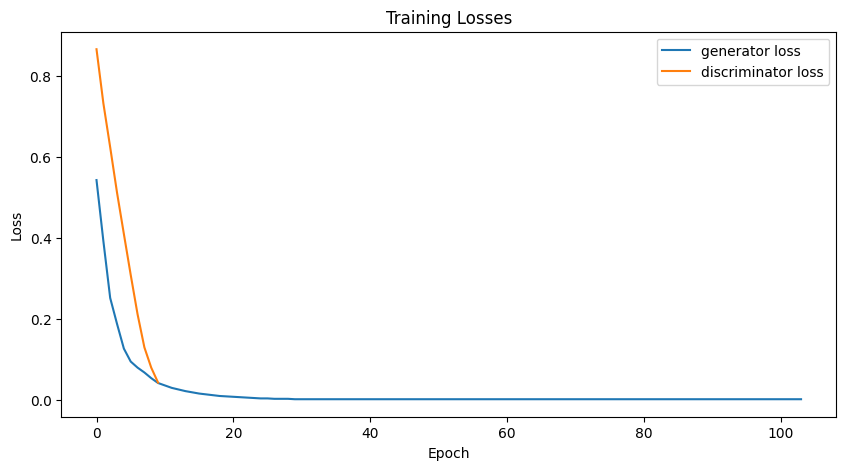

In [17]:
plt.figure(figsize=(10,5))
plt.plot(gen_losses, label='generator loss')
plt.plot(disc_losses, label='discriminator loss')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()